In [1]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import math
import numpy as np
import colorsys
from scipy import optimize as sciopt
import os
import lmfit
import uncertainties as u
import dataset as ds
import datasetXtals as dsX
import fit_functions as funcs
import importlib

Welcome to JupyROOT 6.18/04


In [2]:
plt.style.use(hep.style.ATLAS)
plt.style.use({"axes.labelsize":'36', 'lines.linewidth':'2', 'lines.markersize':'2', 'xtick.labelsize':'16'})

In [4]:
# Reload stuff in case you make changes!

importlib.reload(ds)
importlib.reload(dsX)
importlib.reload(funcs)

<module 'fit_functions' from '/home/lars/g-2/earlyPosition/fit_functions.py'>

In [50]:
global_energy_lim = [0, 100]
global_set_name = '1A'
global_calo_num = 19
fit_lim = [30, 300]

energy_lim = [300, 1000]
low_E  = str(energy_lim[0] / 1000)
high_E = str(energy_lim[1] / 1000)

datasets = {"1A": ["60h", r.TFile("./data/60hXtalsPosition_v2.root")],
            "1B": ["HighKick", r.TFile("./data/highKickXtalsPosition_v2.root")],
            "1C": ["9day", r.TFile("./data/9dayXtalsPosition_v2.root")],
            "1D": ["EndGame", r.TFile("./data/endGameXtalsPosition_v2.root")],
            "2C": ["run2C", r.TFile("./data/run2CXtalsPosition_v2.root")]}

In [51]:
for eLow in range(0, 800, 100):
    energy_lim = [eLow, eLow+100]

    this_low_E  = str(energy_lim[0] / 1000)
    this_high_E = str(energy_lim[1] / 1000)

    dataset = dsX.DataSetX(global_set_name,
                           datasets[global_set_name][0],
                           datasets[global_set_name][1],
                           energy_lim)
    dataset.set_up_one_calo(step_length=10, caloNum=global_calo_num, verbose=False)
    graph_it_up(this_low_E, this_high_E)

In [30]:
def graph_it_up(low_E, high_E):

    model = lmfit.Model(funcs.func0)


    dataX = dataset.calos[global_calo_num].data['randomized']

    fit_data = dataX[(dataX['TimeBin'] > fit_lim[0]) & (dataX['TimeBin'] < fit_lim[1]) ][:]


    model.set_param_hint('c', min=0, max=50)
    model.set_param_hint('m', min=-1, max=1)


    result = model.fit(fit_data['RMS'], t=fit_data['TimeBin'],
                        c=35, m=0,
                       weights=1/fit_data['RMSError'])
    #cov = result.covar

    #print(result.fit_report())

    #time = np.linspace(fit_lim[0],fit_lim[1],100)
    #guess = funcs.func0(t=time, c=35, m=0)

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(20,10)


    ax.errorbar(dataX['TimeBin'], dataX['RMS'], yerr=dataX['RMSError'], color='xkcd:grey', linestyle='none')
    ax.plot(dataX['TimeBin'], dataX['RMS'], linestyle='none', marker='o', markersize=2, label='crystals')
    ax.plot(fit_data['TimeBin'], result.best_fit, label='fit')
    #ax.plot(time, guess, label='guess')

    ax.set_ylabel('y-RMS    [mm]')
    ax.set_xlabel('Time     [μs]')

    ax.set_ylim(28, 40)

    ax.set_title(global_set_name + " Calorimeter " + str(global_calo_num) + "        "+ low_E + "-" + high_E + " GeV", fontsize=40)

    ax.legend(loc=0)

    try:
        plt.savefig("./images/energy_comparison/" + global_set_name + "_Calo" + str(global_calo_num) + "/" + low_E + "-" + high_E + "GeV.png", bbox_inches='tight')
    except FileNotFoundError:
        os.mkdir("./images/energy_comparison/" + global_set_name + "_Calo" + str(global_calo_num) + "/")
        plt.savefig("./images/energy_comparison/" + global_set_name + "_Calo" + str(global_calo_num) + "/" + low_E + "-" + high_E + "GeV.png", bbox_inches='tight')

    plt.close()

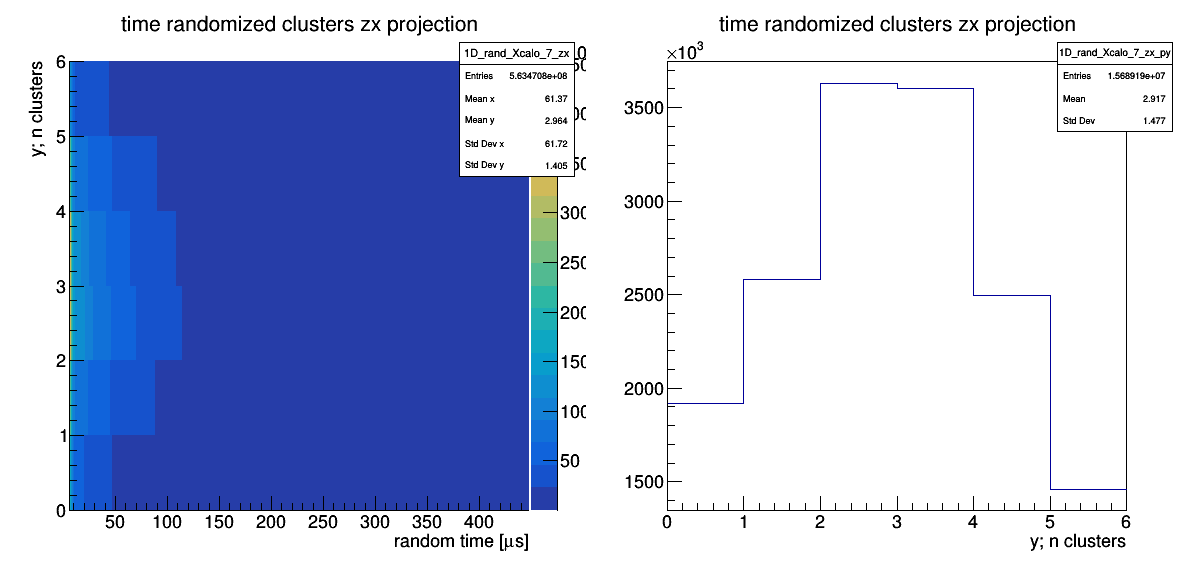

In [8]:

hist = dataset.calos[global_calo_num].hists['randomized']
proj = hist.ProjectionY("_py", 20, 30)

c = r.TCanvas("c", "c", 1200, 600)
c.Divide(2, 1)
c.cd(1)
hist.Draw("colz")
c.cd(2)
proj.Draw()

c.Draw()